# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine 
from dotenv import load_dotenv


In [5]:
load_dotenv(".env")

host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
db = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
pwd = os.getenv("DB_PASSWORD")

DATA_PATH = "afisha_purchases.csv"

query = """
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  CASE
    WHEN LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk::date) IS NULL
      THEN NULL
    ELSE (
      p.created_dt_msk::date
      - LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk::date)
    )::int
  END AS days_since_prev,
  e.event_id,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events  e ON e.event_id  = p.event_id
INNER JOIN afisha.city    c ON c.city_id   = e.city_id
INNER JOIN afisha.regions r ON r.region_id = c.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
"""

try:
    tickets_df = pd.read_csv(DATA_PATH)
    print("Файл загружен")
except FileNotFoundError:
    print("Файл не найден — загружаю из БД")
    conn = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"
    engine = create_engine(conn)

    tickets_df = pd.read_sql_query(query, con=engine)
    tickets_df.to_csv(DATA_PATH, index=False, encoding="utf-8")
    print("Данные загружены из БД и сохранены в CSV")


Файл загружен


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [6]:
print("Размер датасета:", tickets_df.shape)
display(tickets_df.head(5))

tickets_df.info()

Размер датасета: (290611, 14)


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,стендап,Билеты без проблем,Озернинский край,Родниковецк


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                290611 non-null  object 
 1   device_type_canonical  290611 non-null  object 
 2   order_id               290611 non-null  int64  
 3   order_dt               290611 non-null  object 
 4   order_ts               290611 non-null  object 
 5   currency_code          290611 non-null  object 
 6   revenue                290611 non-null  float64
 7   tickets_count          290611 non-null  int64  
 8   days_since_prev        268678 non-null  float64
 9   event_id               290611 non-null  int64  
 10  event_type_main        290611 non-null  object 
 11  service_name           290611 non-null  object 
 12  region_name            290611 non-null  object 
 13  city_name              290611 non-null  object 
dtypes: float64(2), int64(3), object(9)
m

- Всего 290 611 строк, все столбцы присутствуют, их названия в snake_case.
- Столбцы order_dt и order_ts нужно привести к типу datetime, days_since_prev к типу int.
- Пропуски содержатся только в столбце days_since_prev. Однако следует проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
- Судя по первичному знакомству с данными, значения в столбцах соответствуют своему описанию.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_tickets_df.csv`. Его можно загрузить по пути _

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [7]:

file_name = "final_tickets_tenge_tickets_df.csv"
url =  os.getenv("URL")
try:
    tenge_df = pd.read_csv(file_name)
    print("Файл загружен")
except FileNotFoundError:
    print("Файл не найден")
    tenge_df = pd.read_csv(url)
    tenge_df.to_csv(file_name, index=False)
    print("Файл скачан")

Файл загружен


In [8]:
display(tenge_df.info())
tenge_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
tickets_df['order_dt'] = pd.to_datetime(tickets_df['order_dt'])
tickets_df['order_ts'] = pd.to_datetime(tickets_df['order_ts'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

tenge_df['kzt_to_rub'] = tenge_df['curs'] / tenge_df['nominal']

tickets_df = tickets_df.merge(
    tenge_df[['data', 'kzt_to_rub']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

tickets_df['revenue_rub'] = tickets_df.apply(
    lambda x: x['revenue'] * x['kzt_to_rub'] if x['currency_code'] == 'kzt' else x['revenue'],
    axis=1
)

tickets_df.drop(columns=['data', 'kzt_to_rub'], inplace=True)

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [10]:
def show_missing_stats(df):
    ms = pd.DataFrame({
        'Кол-во пропусков': df.isna().sum(),
        'Доля пропусков': df.isna().mean()
    })
    ms = ms[ms['Кол-во пропусков'] > 0].sort_values('Доля пропусков', ascending=False)

    if ms.empty:
        return ms 

    ms['Доля пропусков'] = ms['Доля пропусков'].map(lambda x: f"{x:.4f}")
    return ms

show_missing_stats(tickets_df)


,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


Пропуски только в days_since_prev, они есть если пользователь совершил только одну покупку

In [11]:
tickets_df['days_since_prev'] = tickets_df['days_since_prev'].astype('Int16')
tickets_df['tickets_count'] = pd.to_numeric(tickets_df['tickets_count'], downcast='integer')
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  Int16         
 9   event_id               290611 non-null  int64         
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  obje

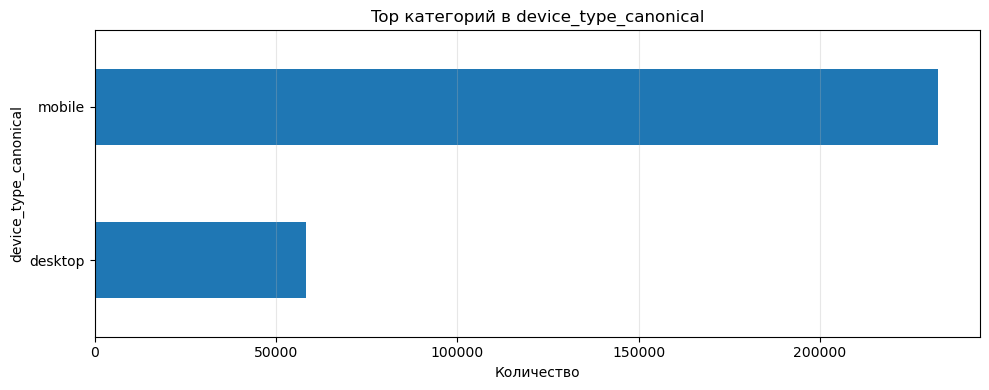

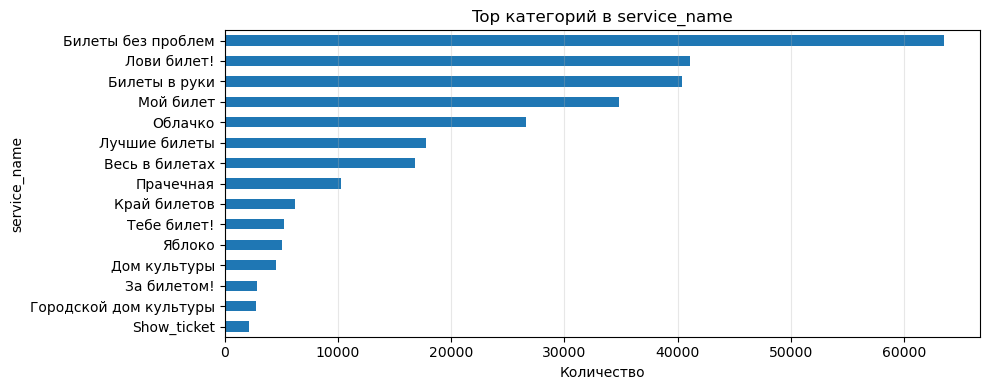

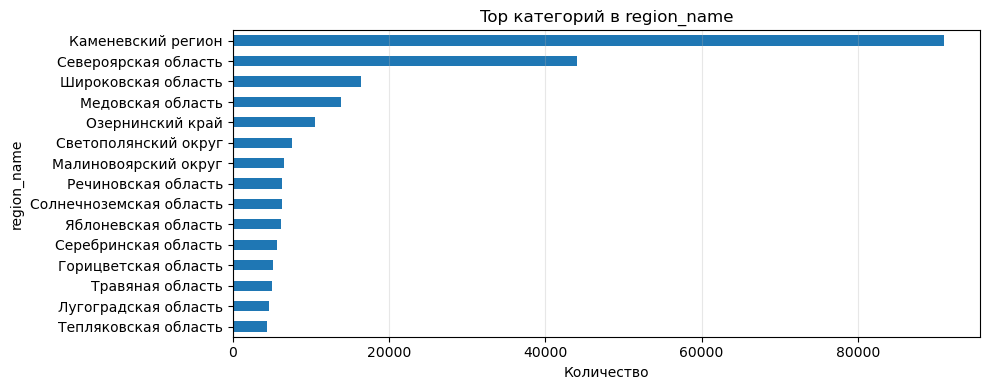

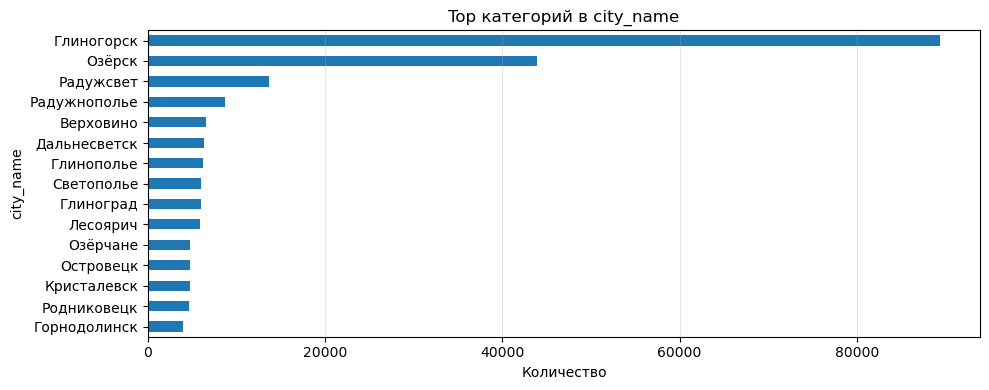

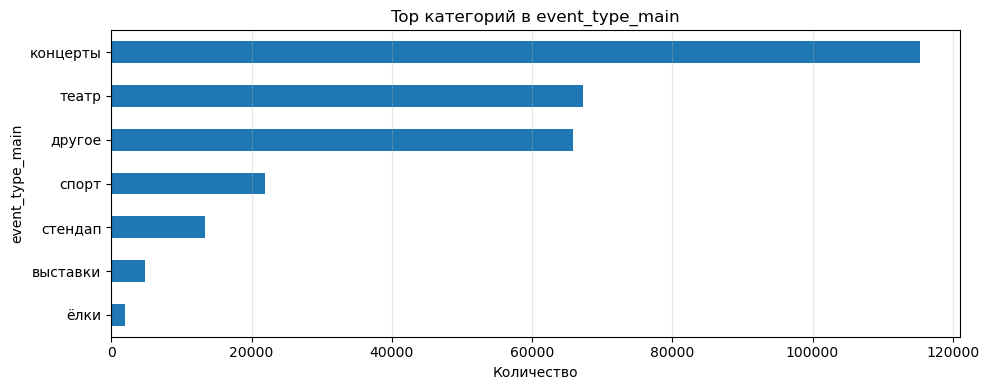

In [12]:
key_nominal = ['device_type_canonical', 'service_name', 'region_name','city_name', 'event_type_main']  # нужные номинальные столбцы

for col in key_nominal:
    vc = tickets_df[col].astype('string').str.strip().value_counts(dropna=False).head(15)
    ax = vc.sort_values().plot(kind='barh', figsize=(10, 4), title=f'Top категорий в {col}')
    ax.set_xlabel('Количество')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

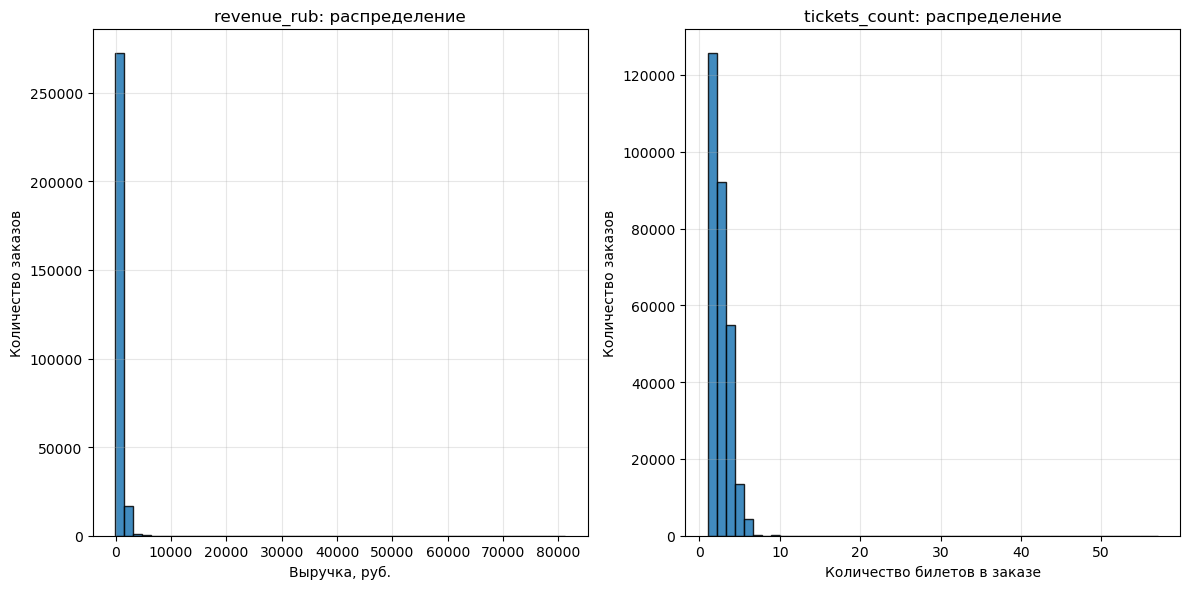

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

tickets_df['revenue_rub'].dropna().plot(kind='hist', bins=50, ax=axes[0], edgecolor='black', alpha=0.85,
                                       title='revenue_rub: распределение')
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_ylabel('Количество заказов')
axes[0].grid(True, alpha=0.3)

tickets_df['tickets_count'].dropna().plot(kind='hist', bins=50, ax=axes[1], edgecolor='black', alpha=0.85,
                                          title='tickets_count: распределение')
axes[1].set_xlabel('Количество билетов в заказе')
axes[1].set_ylabel('Количество заказов')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



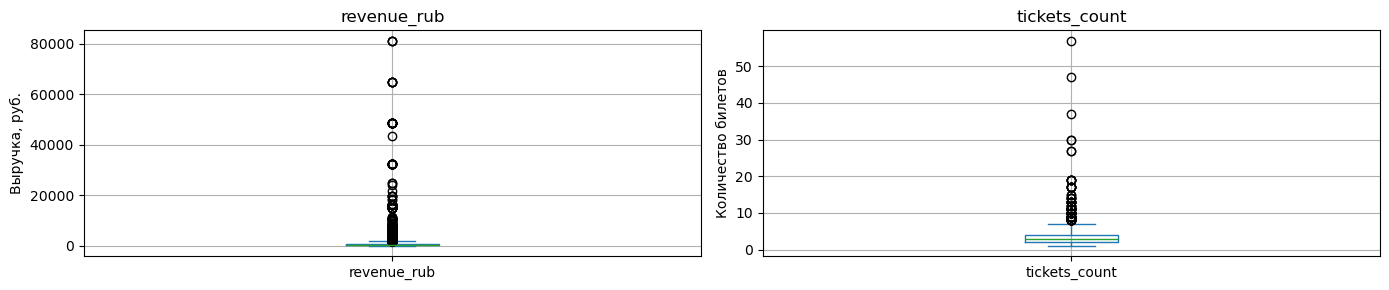

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

tickets_df[['revenue_rub']].plot(kind='box', ax=axes[0], grid=True, title='revenue_rub')
tickets_df[['tickets_count']].plot(kind='box', ax=axes[1], grid=True, title='tickets_count')
axes[0].set_ylabel('Выручка, руб.')
axes[1].set_ylabel('Количество билетов')
plt.tight_layout()
plt.show()


In [15]:
before_n = len(tickets_df)

p99 = tickets_df['revenue_rub'].quantile(0.99)
mask_keep = tickets_df['revenue_rub'] <= p99

filtered_df = tickets_df[mask_keep].copy()

after_n = len(filtered_df)
dropped_n = before_n - after_n
dropped_share = dropped_n / before_n if before_n else 0

summary_filter = pd.DataFrame({
    'Показатель': ['Всего строк до', 'Всего строк после', 'Удалено строк', 'Доля удалённых', 'p99 revenue_rub'],
    'Значение': [before_n, after_n, dropped_n, round(dropped_share, 4), round(float(p99), 2)]
})

display(summary_filter)


,Показатель,Значение
0,Всего строк до,290611.0000
1,Всего строк после,287786.0000
2,Удалено строк,2825.0000
3,Доля удалённых,0.0097
4,p99 revenue_rub,2628.4200


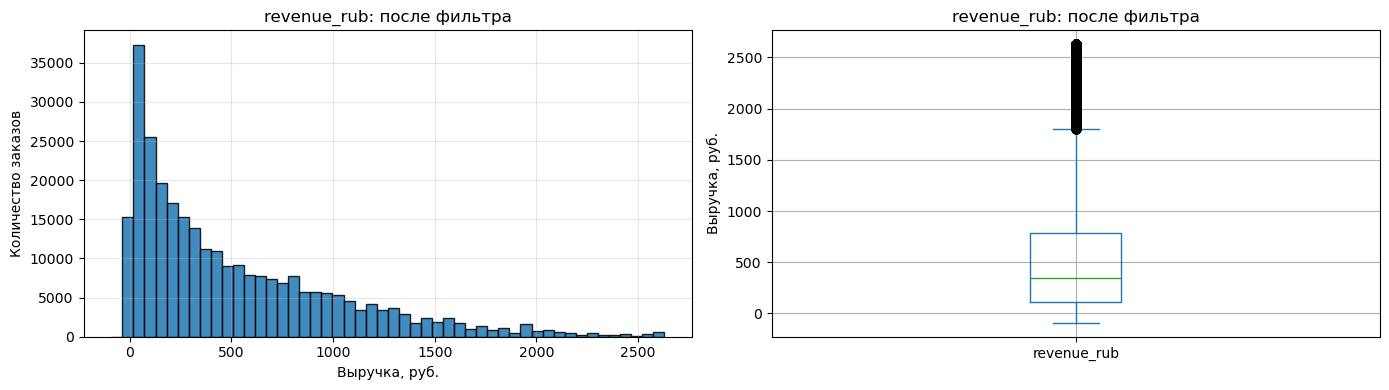

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

filtered_df['revenue_rub'].dropna().plot(kind='hist', bins=50, ax=axes[0], edgecolor='black', alpha=0.85,
                                        title='revenue_rub: после фильтра')
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_ylabel('Количество заказов')
axes[0].grid(True, alpha=0.3)

filtered_df[['revenue_rub']].plot(kind='box', ax=axes[1], grid=True, title='revenue_rub: после фильтра')
axes[1].set_ylabel('Выручка, руб.')
plt.tight_layout()
plt.show()


### Промежуточный вывод по шагу 2

- Привели `order_dt` и `order_ts` к типу `datetime`, чтобы корректно сортировать покупки по времени.
- Выручку привели к единой валюте (рубли): для заказов в тенге использовали курс из файла с ежедневными значениями и рассчитали новый столбец `revenue_rub`.
- Проверили пропуски: ожидаемо основная доля пропусков — в `days_since_prev` (для пользователей с одной покупкой).
- Привели типы числовых столбцов к более компактным и удобным для анализа, проверили категории в ключевых номинальных признаках.
- Проверили распределения `revenue_rub` и `tickets_count`. Для `revenue_rub` отфильтровали выбросы по 99‑му перцентилю (см. таблицу и графики выше).
- Для дальнейшего анализа используем очищенный датасет `tickets_df` (после фильтрации по выбросам выручки).


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [17]:
df = tickets_df.copy()
df = df.sort_values(['user_id', 'order_ts'])

user_profile = (
    df.groupby('user_id', as_index=False)
      .agg(
          first_order_dt=('order_dt', 'first'),
          last_order_dt=('order_dt', 'last'),
          first_device=('device_type_canonical', 'first'),
          first_region=('region_name', 'first'),
          first_service=('service_name', 'first'),
          first_event_type=('event_type_main', 'first'),
          total_orders=('order_id', 'nunique'),
          avg_revenue_rub=('revenue_rub', 'mean'),
          avg_tickets_count=('tickets_count', 'mean'),
          avg_days_between=('days_since_prev', 'mean')
          
      )
)
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype('int8')
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype('int8')
display(user_profile.head())
user_profile.info()


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21933 entries, 0 to 21932
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            21933 non-null  object        
 1   first_order_dt     21933 non-null  datetime64[ns]
 2   last_order_dt      21933 non-null  datetime64[ns]
 3   first_device       21933 non-null  object        
 4   first_region       21933 non-null  object        
 5   first_service      21933 non-null  object        
 6   first_event_type   21933 non-null  object        
 7   total_orders       21933 non-null  int64         
 8   avg_revenue_rub    21933 non-null  float64       
 9   avg_tickets_count  21933 non-null  float64       
 10  avg_days_between   13559 non-null  Float64       
 11  is_two             21933 non-null  int8          
 12  is_five            21933 non-null  int8          
dtypes: Float64(1), datetime64[ns](2), float64(2), int64(1), int8(

- Собрали агрегированный датасет `user_profile`: **одна строка = один пользователь**, а в столбцах — ключевые признаки первого заказа и поведенческие метрики.
- Добавили бинарные флаги `is_two` и `is_five` — базовые целевые признаки для оценки возврата (2+ и 5+ заказов).
- Дальше будем использовать `user_profile` как основную таблицу.


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [18]:
n_users = user_profile['user_id'].nunique()
avg_revenue_per_order = df['revenue_rub'].mean()

share_two = user_profile['is_two'].mean()
share_five = user_profile['is_five'].mean()

base_metrics = pd.DataFrame({
    'Метрика': [
        'Число пользователей',
        'Средняя выручка с заказа (руб.)',
        'Доля пользователей с 2+ заказами',
        'Доля пользователей с 5+ заказами'
    ],
    'Значение': [
        n_users,
        round(avg_revenue_per_order, 2),
        round(share_two, 4),
        round(share_five, 4)
    ]
})

display(base_metrics)

describe_cols = ['total_orders', 'avg_tickets_count', 'avg_days_between']
display(user_profile[describe_cols].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T)

display(user_profile.sort_values('total_orders', ascending=False).head(5))


,Метрика,Значение
0,Число пользователей,21933.0000
1,Средняя выручка с заказа (руб.),555.5700
2,Доля пользователей с 2+ заказами,0.6182
3,Доля пользователей с 5+ заказами,0.2918


,count,mean,std,min,50%,90%,95%,99%,max
total_orders,21933.0,13.249943,122.470535,1.0,2.0,15.0,32.0,152.0,10251.0
avg_tickets_count,21933.0,2.755987,0.920739,1.0,2.764151,4.0,4.0,5.0,12.0
avg_days_between,13559.0,15.808537,22.249582,0.0,8.0,41.333333,61.0,112.0,148.0


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between,is_two,is_five
985,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,Североярская область,Билеты в руки,концерты,10251,523.376768,2.873964,0.014829,1,1
2061,18e9aead0a393e7,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,концерты,4368,508.101194,2.794643,0.034807,1,1
11114,8187dac4be757a0,2024-06-01,2024-10-31,mobile,Берёзовская область,Билеты в руки,концерты,4053,571.896656,2.756970,0.037512,1,1
5432,3ee7dc2e115847f,2024-06-01,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,3826,570.638953,2.776529,0.039739,1,1
10849,7eb4fc207ecc10f,2024-06-01,2024-10-31,mobile,Каменевский регион,Билеты без проблем,театр,3749,570.740409,2.972259,0.040555,1,1


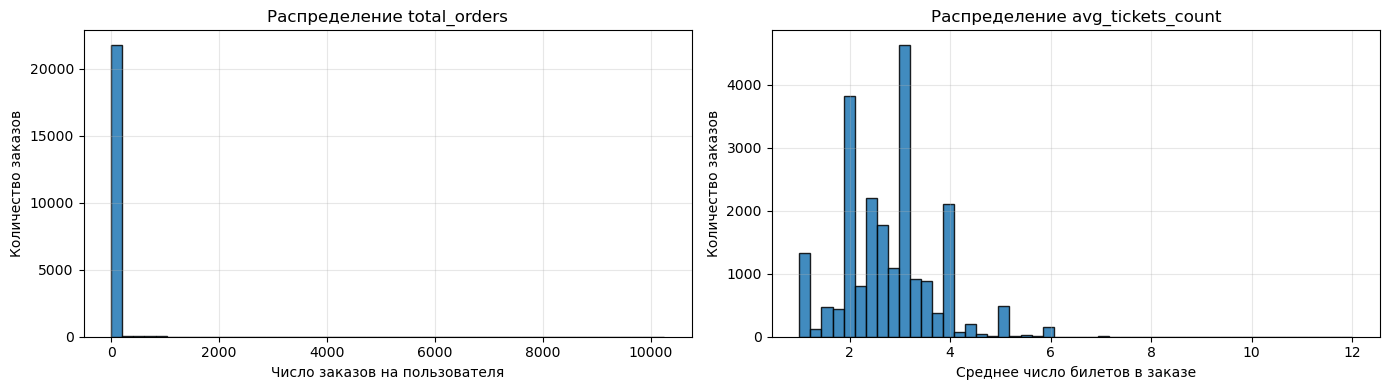

,Показатель,Значение
0,Пользователей до,21933.0000
1,Пользователей после,21505.0000
2,Отфильтровано,428.0000
3,Доля отфильтрованных,0.0195
4,p99 total_orders,152.0000
5,p99 avg_tickets_count,5.0000


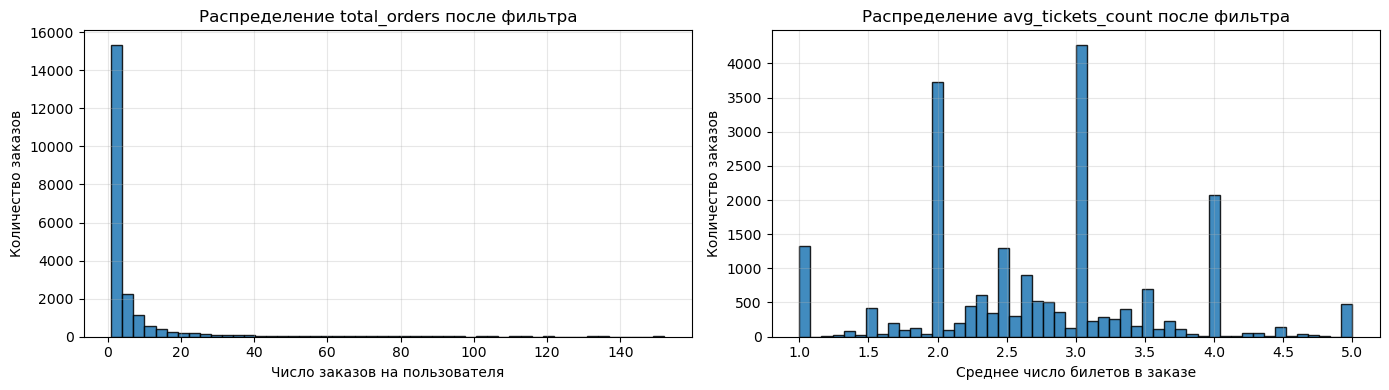

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

user_profile['total_orders'].plot(kind='hist', bins=50, ax=axes[0], edgecolor='black', alpha=0.85,
                                 title='Распределение total_orders')
axes[0].set_xlabel('Число заказов на пользователя')
axes[0].set_ylabel('Количество заказов')
axes[0].grid(True, alpha=0.3)

user_profile['avg_tickets_count'].plot(kind='hist', bins=50, ax=axes[1], edgecolor='black', alpha=0.85,
                                      title='Распределение avg_tickets_count')
axes[1].set_xlabel('Среднее число билетов в заказе')
axes[1].set_ylabel('Количество заказов')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

p99_orders = user_profile['total_orders'].quantile(0.99)
p99_tickets = user_profile['avg_tickets_count'].quantile(0.99)

before_users = len(user_profile)
user_profile_clean = user_profile[
    (user_profile['total_orders'] <= p99_orders) &
    (user_profile['avg_tickets_count'] <= p99_tickets)
].copy()
after_users = len(user_profile_clean)

filter_info = pd.DataFrame({
    'Показатель': ['Пользователей до', 'Пользователей после', 'Отфильтровано', 'Доля отфильтрованных',
                  'p99 total_orders', 'p99 avg_tickets_count'],
    'Значение': [before_users, after_users, before_users - after_users,
                round((before_users - after_users) / before_users if before_users else 0, 4),
                float(p99_orders), float(p99_tickets)]
})
display(filter_info)

# Для дальнейшего анализа используем очищенный профиль
user_profile = user_profile_clean

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

user_profile['total_orders'].plot(kind='hist', bins=50, ax=axes[0], edgecolor='black', alpha=0.85,
                                 title='Распределение total_orders после фильтра')
axes[0].set_xlabel('Число заказов на пользователя')
axes[0].set_ylabel('Количество заказов')
axes[0].grid(True, alpha=0.3)

user_profile['avg_tickets_count'].plot(kind='hist', bins=50, ax=axes[1], edgecolor='black', alpha=0.85,
                                      title='Распределение avg_tickets_count после фильтра')
axes[1].set_xlabel('Среднее число билетов в заказе')
axes[1].set_ylabel('Количество заказов')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


- Рассчитали базовые метрики по выборке (число пользователей, средняя выручка с заказа, доли пользователей с 2+ и 5+ заказами).
- Проверили статистики и распределения ключевых признаков профиля (`total_orders`, `avg_tickets_count`) и посмотрели на пользователей из «хвоста» по числу заказов.
- Чтобы аномальные значения не искажали аналитику, применили фильтрацию по 99‑му перцентилю для `total_orders` и `avg_tickets_count`. Удали 215 аккаунтов (1%).


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.

In [20]:
# Вспомогательные функции для сегментации и визуализации

def segment_distribution(df, col, top_n=None):
    s = df[col].fillna('unknown').astype(str)
    counts = s.value_counts(dropna=False)
    if top_n is not None and len(counts) > top_n:
        top = counts.head(top_n)
        rest = counts.iloc[top_n:].sum()
        counts = pd.concat([top, pd.Series({'other': rest})])
    out = counts.rename('users').to_frame()
    out['share'] = out['users'] / out['users'].sum()
    return out.reset_index(names=col)

def return_rate_by_segment(df, col, target='is_two', top_n=None):
    s = df[col].fillna('unknown').astype(str)
    tmp = df.copy()
    tmp[col] = s

    g = (tmp.groupby(col, as_index=False)
         .agg(users=('user_id', 'nunique'),
              return_rate=(target, 'mean')))

    g = g.sort_values('users', ascending=False)

    if top_n is not None and len(g) > top_n:
        top = g.head(top_n).copy()
        other = pd.DataFrame({
            col: ['other'],
            'users': [g.iloc[top_n:]['users'].sum()],
            'return_rate': [np.average(g.iloc[top_n:]['return_rate'], weights=g.iloc[top_n:]['users'])]
        })
        g = pd.concat([top, other], ignore_index=True)

    g['share'] = g['users'] / g['users'].sum()
    return g

def plot_return_rate(g, segment_col, title, top_n=None):
    g_plot = g.copy()
    if top_n is not None:
        g_plot = g_plot.sort_values('users', ascending=False).head(top_n)

    g_plot = g_plot.sort_values('return_rate', ascending=False)

    fig = plt.figure(figsize=(10, 5))
    plt.bar(g_plot[segment_col].astype(str), g_plot['return_rate'])
    plt.title(title)
    plt.ylabel('Доля пользователей с 2+ заказами')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [21]:
segments = {
    'first_event_type': None,
    'first_device': None,
    'first_region': 10,    
    'first_service': 10     
}

for col, top_n in segments.items():
    dist = segment_distribution(user_profile, col, top_n=top_n)
    display(dist.head(15))

,first_event_type,users,share
0,концерты,9557,0.444408
1,другое,5343,0.248454
2,театр,4226,0.196512
3,стендап,1094,0.050872
4,спорт,783,0.036410
5,выставки,407,0.018926
6,ёлки,95,0.004418


,first_device,users,share
0,mobile,17813,0.828319
1,desktop,3692,0.171681


,first_region,users,share
0,Каменевский регион,7072,0.328854
1,Североярская область,3711,0.172565
2,Широковская область,1215,0.056498
3,Озернинский край,669,0.031109
4,Малиновоярский округ,527,0.024506
5,Шанырский регион,505,0.023483
6,Травяная область,485,0.022553
7,Светополянский округ,460,0.021390
8,Речиновская область,433,0.020135
9,Яблоневская область,409,0.019019


,first_service,users,share
0,Билеты без проблем,5117,0.237945
1,Мой билет,2974,0.138293
2,Лови билет!,2792,0.129830
3,Билеты в руки,2530,0.117647
4,Облачко,2166,0.100721
5,Весь в билетах,1287,0.059847
6,Лучшие билеты,1172,0.054499
7,Прачечная,583,0.027110
8,Край билетов,454,0.021111
9,Дом культуры,349,0.016229


#### Вывод по задаче 4.1.1

- Оценили распределение пользователей по признакам первого заказа и выявили, где сосредоточена основная аудитория.
- Для признаков с большим числом категорий (регионы/операторы) выводили top‑10 сегментов и объединяли остальных в `other`, чтобы фокусироваться на основных точках входа.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


,first_event_type,users,return_rate,share
2,концерты,9557,0.622057,0.444408
1,другое,5343,0.601535,0.248454
5,театр,4226,0.637956,0.196512
4,стендап,1094,0.610603,0.050872
3,спорт,783,0.559387,0.036410
0,выставки,407,0.636364,0.018926
6,ёлки,95,0.547368,0.004418


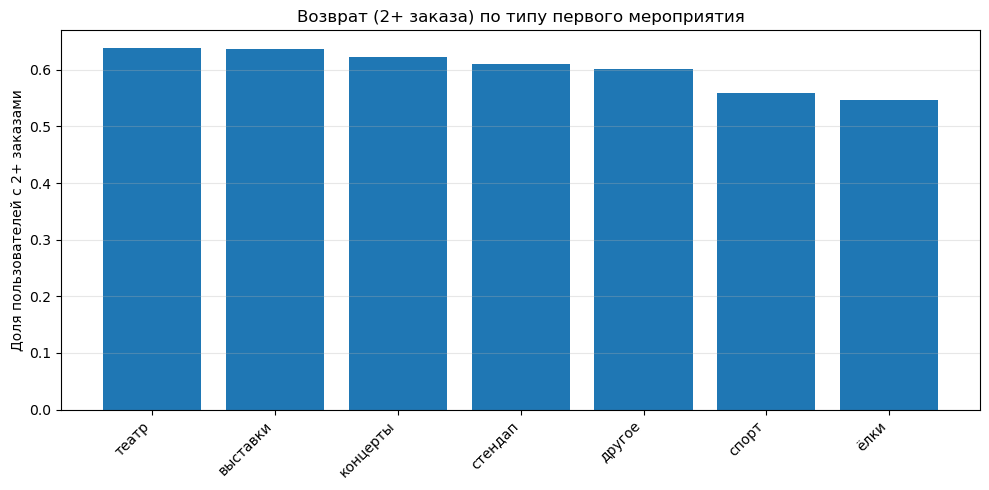

,first_device,users,return_rate,share
1,mobile,17813,0.611913,0.828319
0,desktop,3692,0.642470,0.171681


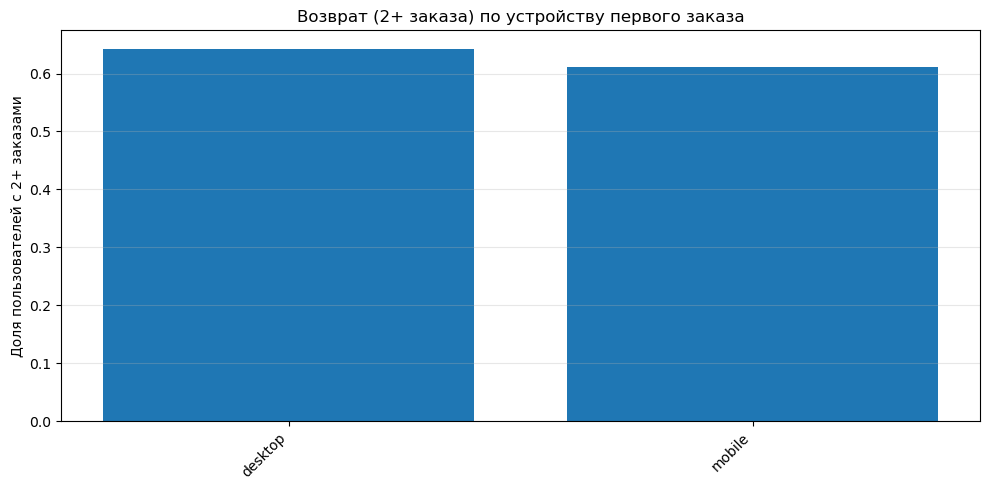

,first_region,users,return_rate,share
0,Каменевский регион,7072,0.627121,0.328854
1,Североярская область,3711,0.642414,0.172565
2,Широковская область,1215,0.653498,0.056498
3,Озернинский край,669,0.554559,0.031109
4,Малиновоярский округ,527,0.561670,0.024506
5,Шанырский регион,505,0.685149,0.023483
6,Травяная область,485,0.618557,0.022553
7,Светополянский округ,460,0.658696,0.021390
8,Речиновская область,433,0.635104,0.020135
9,Яблоневская область,409,0.601467,0.019019


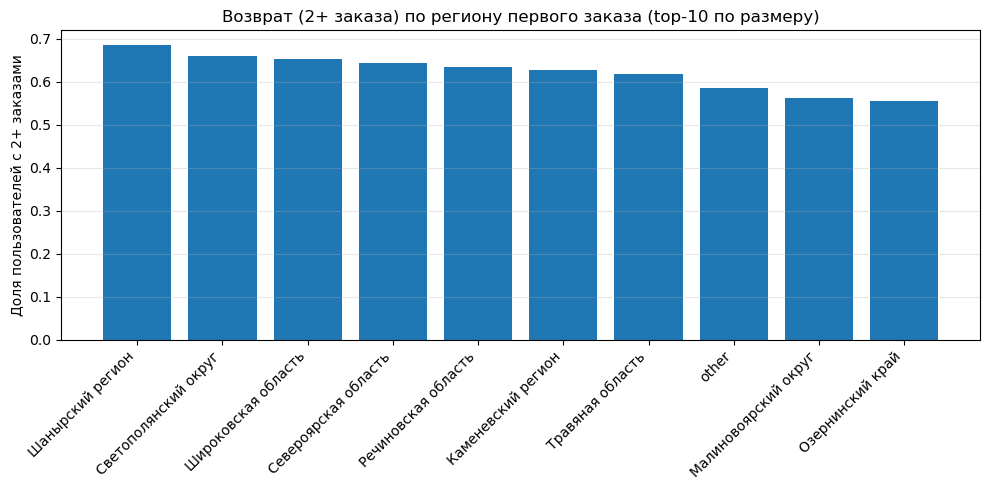

,first_service,users,return_rate,share
0,Билеты без проблем,5117,0.609928,0.237945
1,Мой билет,2974,0.611634,0.138293
2,Лови билет!,2792,0.613897,0.129830
3,Билеты в руки,2530,0.628458,0.117647
4,Облачко,2166,0.614958,0.100721
5,Весь в билетах,1287,0.634033,0.059847
6,Лучшие билеты,1172,0.616041,0.054499
7,Прачечная,583,0.629503,0.027110
8,Край билетов,454,0.651982,0.021111
9,Дом культуры,349,0.653295,0.016229


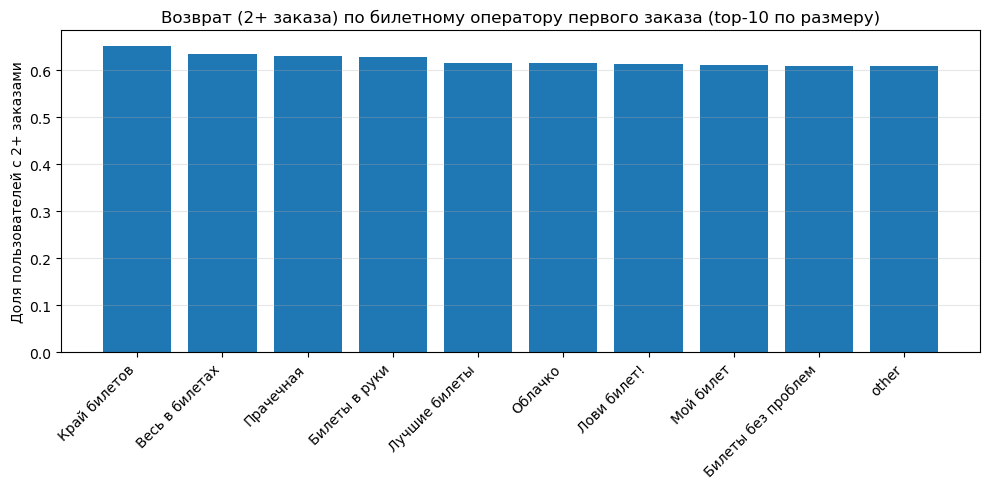

In [22]:
# event type
g_event = return_rate_by_segment(user_profile, 'first_event_type', top_n=None)
display(g_event.sort_values('users', ascending=False).head(15))
plot_return_rate(g_event, 'first_event_type', 'Возврат (2+ заказа) по типу первого мероприятия')

# device
g_device = return_rate_by_segment(user_profile, 'first_device', top_n=None)
display(g_device)
plot_return_rate(g_device, 'first_device', 'Возврат (2+ заказа) по устройству первого заказа')

# region (top 10)
g_region = return_rate_by_segment(user_profile, 'first_region', top_n=10)
display(g_region)
plot_return_rate(g_region.sort_values('users', ascending=False).head(10), 'first_region',
                 'Возврат (2+ заказа) по региону первого заказа (top-10 по размеру)')

# service (top 10)
g_service = return_rate_by_segment(user_profile, 'first_service', top_n=10)
display(g_service)
plot_return_rate(g_service.sort_values('users', ascending=False).head(10), 'first_service',
                 'Возврат (2+ заказа) по билетному оператору первого заказа (top-10 по размеру)')

Нет прям выделенного сегмента, в котором пользователи чаще возвращаются, везде примерно 60%.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

,Сегмент,users,return_rate_is_two
0,спорт,783,0.559387
1,концерты,9557,0.622057


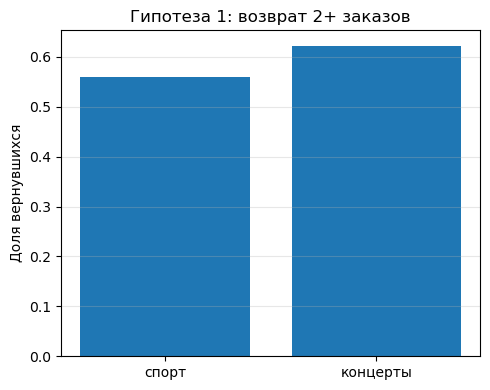

,region_group,users,return_rate_is_two
0,other regions,6019,0.585147
1,top-10 regions,15486,0.629601


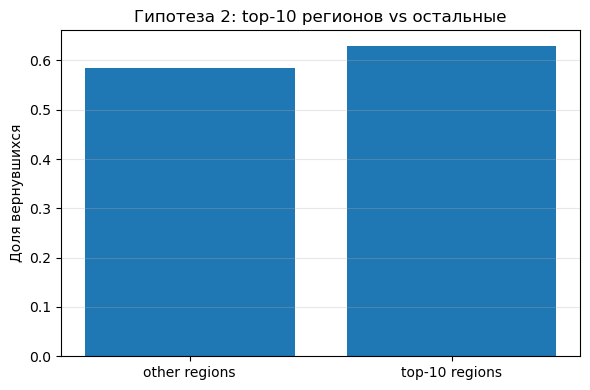

In [23]:
# Гипотеза 1: спорт vs концерты
tmp = user_profile.copy()
tmp['first_event_type_lc'] = tmp['first_event_type'].fillna('unknown').astype(str).str.lower()

sport_mask = tmp['first_event_type_lc'].str.contains('спорт', na=False)
concert_mask = tmp['first_event_type_lc'].str.contains('концерт', na=False)

h1 = pd.DataFrame({
    'Сегмент': ['спорт', 'концерты'],
    'users': [tmp.loc[sport_mask, 'user_id'].nunique(), tmp.loc[concert_mask, 'user_id'].nunique()],
    'return_rate_is_two': [tmp.loc[sport_mask, 'is_two'].mean(), tmp.loc[concert_mask, 'is_two'].mean()]
})
display(h1)

fig = plt.figure(figsize=(5, 4))
plt.bar(h1['Сегмент'], h1['return_rate_is_two'])
plt.title('Гипотеза 1: возврат 2+ заказов')
plt.ylabel('Доля вернувшихся')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Гипотеза 2: top-10 регионов vs остальные
region_users = (tmp.groupby('first_region', as_index=False)
                .agg(users=('user_id', 'nunique'),
                     return_rate=('is_two', 'mean'))
                .sort_values('users', ascending=False))

top_regions = set(region_users.head(10)['first_region'].astype(str))
tmp['region_group'] = np.where(tmp['first_region'].astype(str).isin(top_regions), 'top-10 regions', 'other regions')

h2 = tmp.groupby('region_group', as_index=False).agg(
    users=('user_id', 'nunique'),
    return_rate_is_two=('is_two', 'mean')
)
display(h2)

fig = plt.figure(figsize=(6, 4))
plt.bar(h2['region_group'], h2['return_rate_is_two'])
plt.title('Гипотеза 2: top-10 регионов vs остальные')
plt.ylabel('Доля вернувшихся')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- Гипотеза 1: не подтвердилась, это было заметно ещё в прошлом анализе, так как пользователи, которые в свой первый раз посетили спортивное мероприятие, возвращаются с самой меньшей вероятностью.
- Гипотеза 2: подтвердилась, в среднем количество пользователей в регионе коррелирует положительно с вероятностью повторного заказа.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [24]:
orders = tickets_df.drop_duplicates('order_id').copy()

orders['revenue_per_ticket_rub'] = np.where(
    orders['tickets_count'] > 0,
    orders['revenue_rub'] / orders['tickets_count'],
    np.nan
)

user_rev_ticket = (orders.groupby('user_id', as_index=False)
                   .agg(avg_revenue_per_ticket_rub=('revenue_per_ticket_rub', 'mean')))

user_profile = user_profile.merge(user_rev_ticket, on='user_id', how='left')

display(user_profile[['avg_revenue_rub', 'avg_revenue_per_ticket_rub']].describe())

,avg_revenue_rub,avg_revenue_per_ticket_rub
count,21505.000000,21505.000000
mean,570.012709,207.563807
std,551.400097,174.411288
min,-10.770000,-3.590000
25%,211.840000,84.573426
50%,470.752000,187.890000
75%,784.120000,292.292500
max,16738.696667,5602.373889


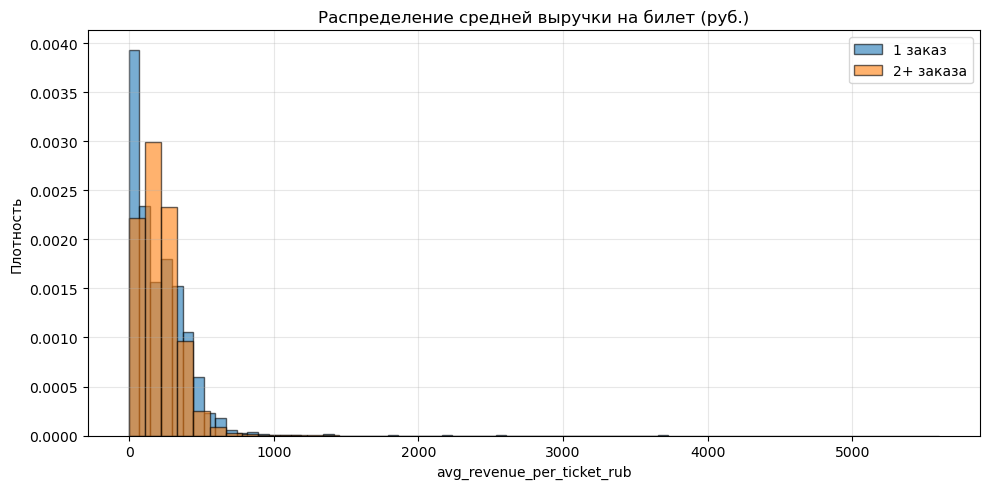

,Группа,users,mean,median
0,1 заказ,8233,204.573178,166.273333
1,2+ заказа,13272,209.418979,194.287743


In [25]:
one_time = user_profile[user_profile['is_two'] == 0]['avg_revenue_per_ticket_rub'].dropna()
returning = user_profile[user_profile['is_two'] == 1]['avg_revenue_per_ticket_rub'].dropna()
fig = plt.figure(figsize=(10, 5))
plt.hist(one_time, bins=50, density=True, alpha=0.6, edgecolor='black', label='1 заказ')
plt.hist(returning, bins=50, density=True, alpha=0.6, edgecolor='black', label='2+ заказа')
plt.title('Распределение средней выручки на билет (руб.)')
plt.xlabel('avg_revenue_per_ticket_rub')
plt.ylabel('Плотность')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

display(pd.DataFrame({
    'Группа': ['1 заказ', '2+ заказа'],
    'users': [one_time.shape[0], returning.shape[0]],
    'mean': [one_time.mean(), returning.mean()],
    'median': [one_time.median(), returning.median()]
}))

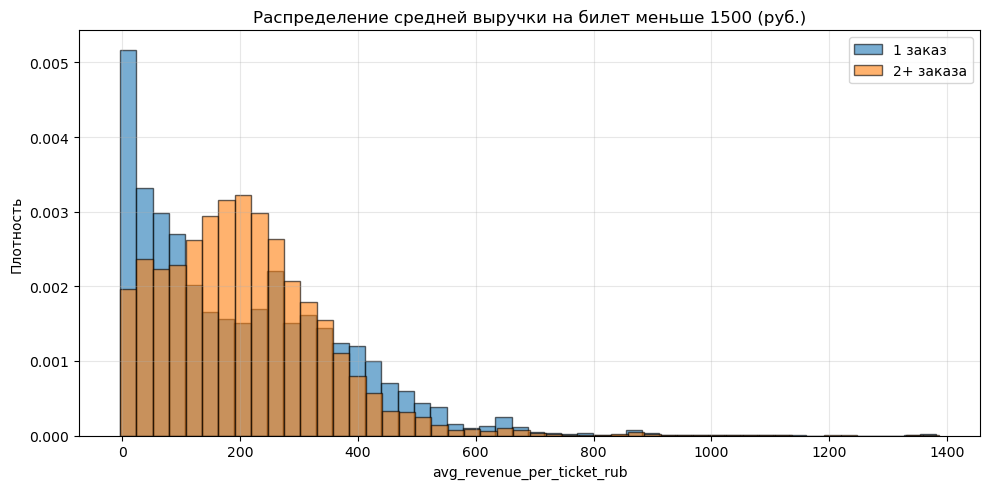

In [26]:
one_time = user_profile[(user_profile['is_two'] == 0) & (user_profile['avg_revenue_per_ticket_rub']<1500)]['avg_revenue_per_ticket_rub'].dropna()
returning = user_profile[(user_profile['is_two'] == 1) & (user_profile['avg_revenue_per_ticket_rub']<1500)]['avg_revenue_per_ticket_rub'].dropna()

fig = plt.figure(figsize=(10, 5))
plt.hist(one_time, bins=50, density=True, alpha=0.6, edgecolor='black', label='1 заказ')
plt.hist(returning, bins=50, density=True, alpha=0.6, edgecolor='black', label='2+ заказа')
plt.title('Распределение средней выручки на билет меньше 1500 (руб.)')
plt.xlabel('avg_revenue_per_ticket_rub')
plt.ylabel('Плотность')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

- Пользователи, совершившие только одну покупку, в среднем приобретают билеты более низкой стоимости по сравнению с пользователями, сделавшими два и более заказа.

- У one-time пользователей стоимость билетов преимущественно концентрируется в диапазоне 0–100 рублей, тогда как у возвращающихся пользователей основная масса покупок приходится на диапазон 150–250 рублей.

- Возможным объяснением является то, что пользователи, совершившие единственную покупку, приобретали билет по значительной скидке. После такой разовой покупки они не сформировали привычку пользоваться сервисом и в дальнейшем не возвращались.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


,Группа,users,mean,median
0,2–4 заказа,7102,577.339906,474.595833
1,5+ заказов,6170,576.204824,524.794762


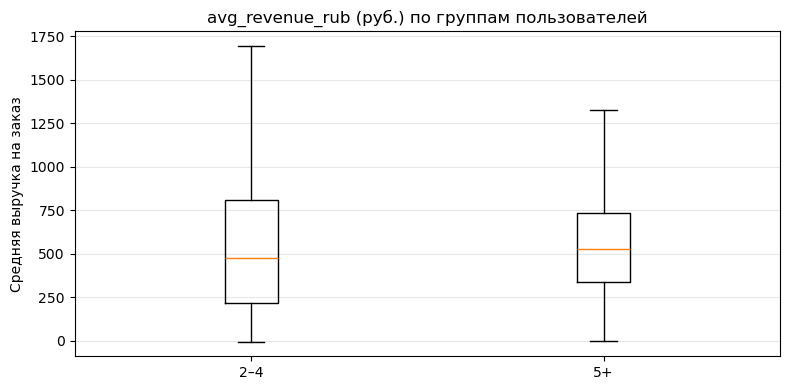

In [27]:
g_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]['avg_revenue_rub'].dropna()
g_5p = user_profile[user_profile['total_orders'] >= 5]['avg_revenue_rub'].dropna()

display(pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'users': [len(g_2_4), len(g_5p)],
    'mean': [g_2_4.mean(), g_5p.mean()],
    'median': [g_2_4.median(), g_5p.median()]
}))

fig = plt.figure(figsize=(8, 4))
plt.boxplot([g_2_4, g_5p], tick_labels=['2–4', '5+'], showfliers=False)
plt.title('avg_revenue_rub (руб.) по группам пользователей')
plt.ylabel('Средняя выручка на заказ')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- Медиана у 5+ выше, но средняя выручка практически не отличается.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

,tickets_segment,users,return_rate,share
1,2–3,9881,0.742131,0.459475
0,1–2,6120,0.400490,0.284585
2,3–5,5504,0.633721,0.255940
3,5+,0,NaN,0.000000


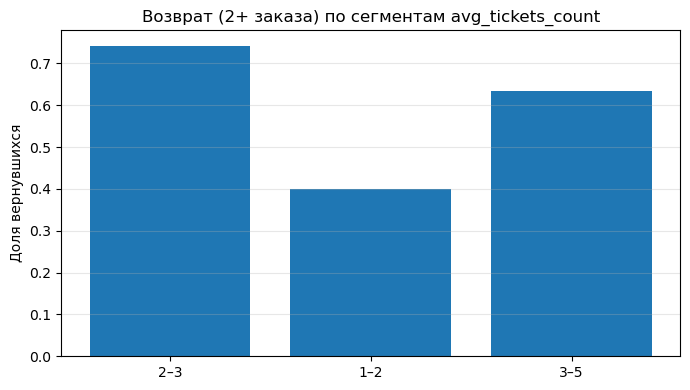

In [28]:
tmp = user_profile.copy()

bins = [1, 2, 3, 5, np.inf]
labels = ['1–2', '2–3', '3–5', '5+']

tmp['tickets_segment'] = pd.cut(tmp['avg_tickets_count'], bins=bins, labels=labels, right=True, include_lowest=True)

seg_tickets = (tmp.groupby('tickets_segment', as_index=False,observed=False)
               .agg(users=('user_id', 'nunique'),
                    return_rate=('is_two', 'mean'))
               .sort_values('users', ascending=False))

seg_tickets['share'] = seg_tickets['users'] / seg_tickets['users'].sum()
display(seg_tickets)

fig = plt.figure(figsize=(7, 4))
plt.bar(seg_tickets['tickets_segment'].astype(str), seg_tickets['return_rate'])
plt.title('Возврат (2+ заказа) по сегментам avg_tickets_count')
plt.ylabel('Доля вернувшихся')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- Пользователи, которые в среднем покупают билеты только на себя, возвращаются примерно в 40% случаев. При этом те, кто чаще оформляет заказы на компанию (2+ билета), возвращаются заметно чаще.

- Максимальная доля повторных покупок(74%) — наблюдается у пользователей, которые обычно покупают 2–3 билета.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


,first_order_dow,users,return_rate
0,Monday,2908,0.633425
1,Tuesday,3171,0.625039
2,Wednesday,3037,0.626276
3,Thursday,3092,0.597671
4,Friday,3244,0.601726
5,Saturday,3296,0.629854
6,Sunday,2757,0.605731


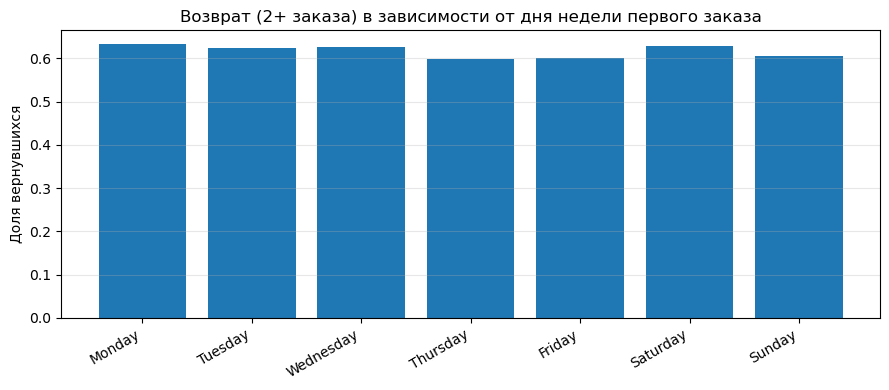

In [29]:
tmp = user_profile.copy()
tmp['first_order_dow'] = tmp['first_order_dt'].dt.day_name()

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tmp['first_order_dow'] = pd.Categorical(tmp['first_order_dow'], categories=dow_order, ordered=True)

dow_stats = (tmp.groupby('first_order_dow', as_index=False, observed=False)
             .agg(users=('user_id', 'nunique'),
                  return_rate=('is_two', 'mean'))
             .sort_values('first_order_dow'))


display(dow_stats)

fig = plt.figure(figsize=(9, 4))
plt.bar(dow_stats['first_order_dow'].astype(str), dow_stats['return_rate'])
plt.title('Возврат (2+ заказа) в зависимости от дня недели первого заказа')
plt.ylabel('Доля вернувшихся')
plt.xticks(rotation=30, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- День недели первого заказа не оказывает заметного влияния на вероятность повторной покупки.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


,Группа,users,mean_gap_days,median_gap_days
0,2–4 заказа,7102,21.442551,9.0
1,5+ заказов,6170,9.972952,8.2


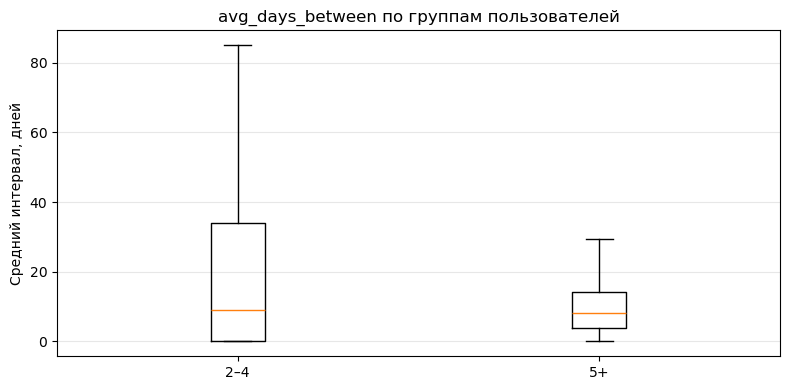

In [30]:
g_2_4_gap = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]['avg_days_between'].dropna()
g_5p_gap = user_profile[user_profile['total_orders'] >= 5]['avg_days_between'].dropna()

display(pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'users': [len(g_2_4_gap), len(g_5p_gap)],
    'mean_gap_days': [g_2_4_gap.mean(), g_5p_gap.mean()],
    'median_gap_days': [g_2_4_gap.median(), g_5p_gap.median()]
}))

fig = plt.figure(figsize=(8, 4))
plt.boxplot([g_2_4_gap, g_5p_gap], tick_labels=['2–4', '5+'], showfliers=False)
plt.title('avg_days_between по группам пользователей')
plt.ylabel('Средний интервал, дней')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- Короткий интервал между заказами (примерно до 10–15 дней) характерен для пользователей, которые с большей вероятностью продолжают покупать и переходят в сегмент 5+ заказов.

- Длинные интервалы (особенно “редкие, но большие”) ассоциированы с тем, что пользователь остаётся на уровне 2–4 заказов и не формирует регулярность.

- Так как медианы почти одинаковые, ключевая проблема не в типичном интервале, а в том, что у части пользователей возникает долгая пауза, которая обрывает повторные покупки.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

,total_orders,avg_revenue_rub,avg_revenue_per_ticket_rub,avg_tickets_count,avg_days_between,first_device,first_region,first_service,first_event_type
total_orders,1.000000,0.000000,0.000000,0.383927,0.286294,0.027622,0.117121,0.023802,0.024982
avg_revenue_rub,0.000000,1.000000,0.882163,0.240004,0.000000,0.013122,0.000000,0.139071,0.090925
avg_revenue_per_ticket_rub,0.000000,0.882163,1.000000,0.026011,0.000000,0.015762,0.046399,0.173718,0.091744
avg_tickets_count,0.383927,0.240004,0.026011,1.000000,0.167421,0.059668,0.142559,0.084069,0.089608
avg_days_between,0.286294,0.000000,0.000000,0.167421,1.000000,0.018554,0.081074,0.052869,0.051435
first_device,0.027622,0.013122,0.015762,0.059668,0.018554,1.000000,0.116389,0.084127,0.062363
first_region,0.117121,0.000000,0.046399,0.142559,0.081074,0.116389,1.000000,0.696711,0.507461
first_service,0.023802,0.139071,0.173718,0.084069,0.052869,0.084127,0.696711,1.000000,0.586595
first_event_type,0.024982,0.090925,0.091744,0.089608,0.051435,0.062363,0.507461,0.586595,1.000000


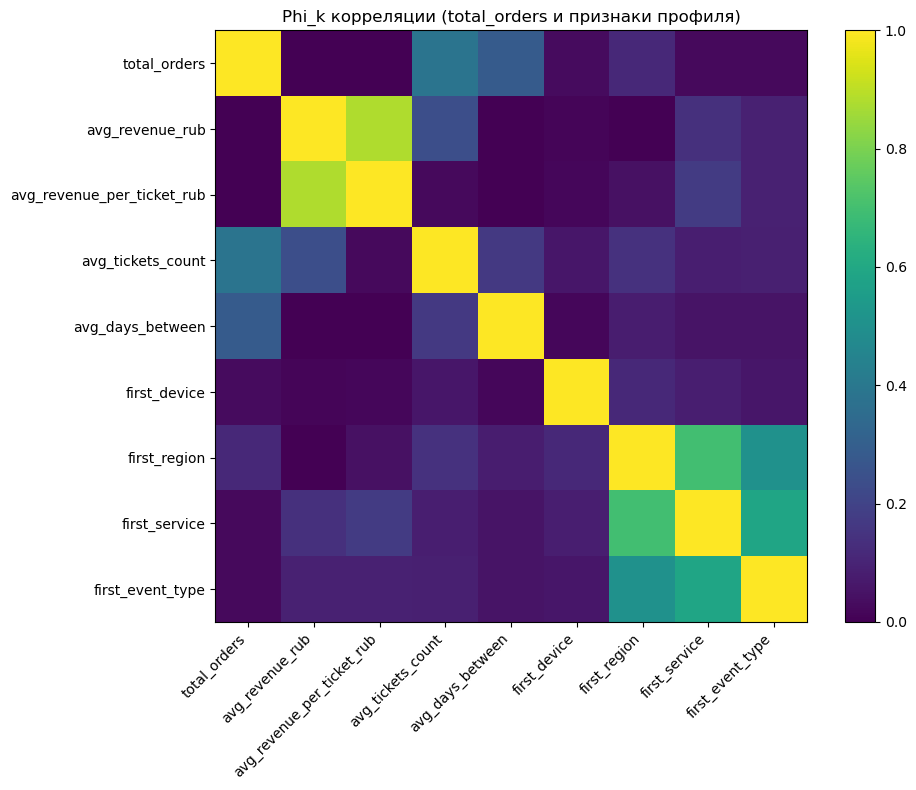

total_orders                  1.000000
avg_tickets_count             0.383927
avg_days_between              0.286294
first_region                  0.117121
first_device                  0.027622
first_event_type              0.024982
first_service                 0.023802
avg_revenue_rub               0.000000
avg_revenue_per_ticket_rub    0.000000
Name: total_orders, dtype: float64

In [31]:
corr_df = user_profile[[
    'total_orders',
    'avg_revenue_rub',
    'avg_revenue_per_ticket_rub',
    'avg_tickets_count',
    'avg_days_between',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]].copy()

interval_cols = ['total_orders', 'avg_revenue_rub', 'avg_revenue_per_ticket_rub', 'avg_tickets_count', 'avg_days_between']
corr_df = corr_df.dropna(subset=['total_orders'])

phi = corr_df.phik_matrix(interval_cols=interval_cols)
display(phi)

fig = plt.figure(figsize=(10, 8))
plt.imshow(phi.values)
plt.xticks(range(len(phi.columns)), phi.columns, rotation=45, ha='right')
plt.yticks(range(len(phi.index)), phi.index)
plt.title('Phi_k корреляции (total_orders и признаки профиля)')
plt.colorbar()
plt.tight_layout()
plt.show()

display(phi['total_orders'].sort_values(ascending=False))

По столбцу total_orders в матрице phi_k самые большие значения корреляции:

avg_tickets_count — 0.416
Это самая сильная связь: чем больше в среднем билетов покупает пользователь в одном заказе, тем больше у него, как правило, общее число заказов.

avg_days_between — 0.367
Умеренная связь: пользователи с более “регулярным” поведением (меньшие/стабильные интервалы между заказами) чаще имеют больше заказов.

Дальше идут слабые связи, которые почти не объясняют количество заказов:

first_region — 0.076

first_device — 0.037

first_event_type — 0.033

avg_revenue_per_ticket_rub — 0.019

first_service — 0.013

---

## Промежуточный общий вывод по шагу 4
В шаге 4 мы изучили, какие факторы связаны с повторными покупками (2+ заказа) и ростом числа заказов. Общая картина такая: на удержание сильнее всего влияют поведенческие характеристики пользователя, а не параметры “контекста” первого заказа (день недели, устройство и т. п.).

Ключевые наблюдения:

- Среднее число билетов в заказе (avg_tickets_count) связано с удержанием сильнее всего.
Пользователи, которые в среднем покупают билеты только на себя, возвращаются примерно в 40% случаев. При покупке 2+ билетов возврат существенно выше, а максимальная доля повторных покупок наблюдается в сегменте 2–3 билета (около 74%).

- Цена/выручка на билет отличается между группами.
Пользователи с 1 заказом чаще покупают билеты более низкой стоимости (концентрация в диапазоне 0–100 руб.), тогда как у пользователей с 2+ заказами покупки смещены в диапазон 150–250 руб.. Возможная причина — часть “одноразовых” пользователей совершает покупку по сильной скидке и не формирует привычку пользоваться сервисом.

- День недели первого заказа существенного влияния на возврат не оказывает.
Уровень повторных покупок по дням недели отличается незначительно.

- Регулярность покупок важна для роста числа заказов.
У пользователей с 5+ заказами средний интервал между покупками заметно меньше, чем у пользователей с 2–4 заказами. При этом у группы 2–4 заказа наблюдаются длинные паузы, которые, вероятно, приводят к остановке активности.

- Корреляционный анализ (phi_k) подтверждает выводы.
Наиболее связаны с количеством заказов: avg_tickets_count (phi_k ≈ 0.416) и avg_days_between (phi_k ≈ 0.367). Остальные признаки (устройство, регион, сервис, тип события первого заказа) имеют слабые связи.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Данные и их подготовка**

- В работе использовались данные по пользователям и их заказам, на базе которых были рассчитаны пользовательские метрики: total_orders, is_two, avg_revenue_rub, avg_revenue_per_ticket_rub, avg_tickets_count, avg_days_between, а также признаки первого заказа (first_device, first_region, first_service, first_event_type).

- Выполнена базовая подготовка: обработка пропусков, проверка распределений и выбросов. Для корректной визуализации и сравнения распределений в отдельных местах применялась фильтрация значений.

**Основные результаты анализа**

- Признаки первого заказа слабо связаны с возвратом: день недели, устройство, регион, сервис и тип события не показывают выраженного влияния на повторные покупки.

- Поведенческие признаки — ключевые драйверы удержания:

    - пользователи, покупающие 2–3 билета, возвращаются чаще всего (примерно 74%);

    - пользователи, покупающие в среднем 1 билет, возвращаются заметно реже (около 40%).

- Ценовой фактор влияет на удержание: у “одноразовых” пользователей стоимость билетов чаще ниже, что может быть связано с покупками по сильным скидкам.

- Временные характеристики: день недели первого заказа не важен, но интервалы между заказами хорошо различают “слабых” и “сильных” пользователей — частые пользователи делают покупки с меньшими паузами.

- Корреляция phi_k с числом заказов: наиболее связаны avg_tickets_count и avg_days_between; остальные признаки имеют слабые корреляции.

**Рекомендации**

- Фокус на сегменте “2–3 билета”
Это самый перспективный сегмент по удержанию. Имеет смысл усиливать сценарии покупки “на компанию”: групповые предложения, механики “пригласи друга”, персональные подборки мероприятий, где чаще ходят вдвоём/втроём.

- Работа с риском длинных пауз
Настроить триггерные коммуникации после заказа (например, на 7–14 день и на 21–30 день): рекомендации, напоминания, персональные подборки — чтобы предотвращать уход в длинные интервалы.

- Осторожнее со “сильной скидкой на первый заказ”
Если скидка приводит к покупке крайне дешёвого билета, это может увеличивать долю “разовых” пользователей. Стоит тестировать альтернативы: бонус на второй заказ, кэшбэк после первого заказа, скидка на повторную покупку.

- Не делать ставку на статические признаки первого заказа
Устройство, регион, тип события и сервис первого заказа дают мало сигнала для удержания и числа заказов. Для таргетинга лучше использовать поведенческие признаки (avg_tickets_count, признаки регулярности, ценовой уровень).


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/4danm0/Analysis_of_Yandex_Afisha